# MODELING

In [24]:
import polars as pl
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from utils import TEMP_ORDER, predict_from_model, predict_with_ci

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
SF_COLOR = "#C83200"
OTHER_COLOR = "#0C5DA5"

In [25]:
# read in data
defense_df = pl.read_parquet("../data/defense_season_stats.parquet")
games_df = pl.read_parquet("../data/games_full_data.parquet")
qb_df = pl.read_parquet("../data/qb_game_stats.parquet")

In [26]:
# join all data together 

model_df = (
    qb_df
    # Filter out QBs with fewer than 5 dropbacks (trick plays, emergency snaps)
    # These produce extreme EPA/dropback values and are not representative of QB performance
    .filter(pl.col("dropbacks") >= 5)
    .join(
        games_df.select([
            "game_id",
            "season",
            "is_soldier_field",
            "temp",
            "wind",
            "precip",
            "temp_bin",
        ]),
        on="game_id",
        how="inner",
    )
    .join(
        defense_df.select([
            "season",
            "defense_team",
            "def_epa_allowed_season",
        ]),
        on=["season", "defense_team"],
        how="left",
    )
    .with_columns([
        (pl.col("temp") - pl.col("temp").mean()).alias("temp_c"),
        (pl.col("wind") - pl.col("wind").mean()).alias("wind_c"),
        (pl.col("def_epa_allowed_season") - pl.col("def_epa_allowed_season").mean()).alias("opp_def_epa_c"),
    ])
    .select([
        "game_id",
        "epa_per_dropback",
        pl.col("is_home").cast(pl.Int8).alias("is_home"),
        pl.col("is_soldier_field").cast(pl.Int8).alias("soldier_field"),
        "temp_c",
        "wind_c",
        pl.col("precip").cast(pl.Int8).alias("precip"),
        "opp_def_epa_c",
        "temp_bin",
    ])
)

In [27]:
# Convert to pandas for statsmodels
pdf = model_df.to_pandas()
pdf["temp_bin"] = pd.Categorical(
    pdf["temp_bin"],
    categories=["below_32", "32_to_50", "above_50"],
    ordered=True
)

# EXPLORATORY DATA ANALYSIS

Before modeling, we examine the distribution of the dependent variable and its relationships with key predictors.

/var/folders/0m/4j64n2155lg5lppxkrwsngrr0000gn/T/ipykernel_7570/2878688229.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(


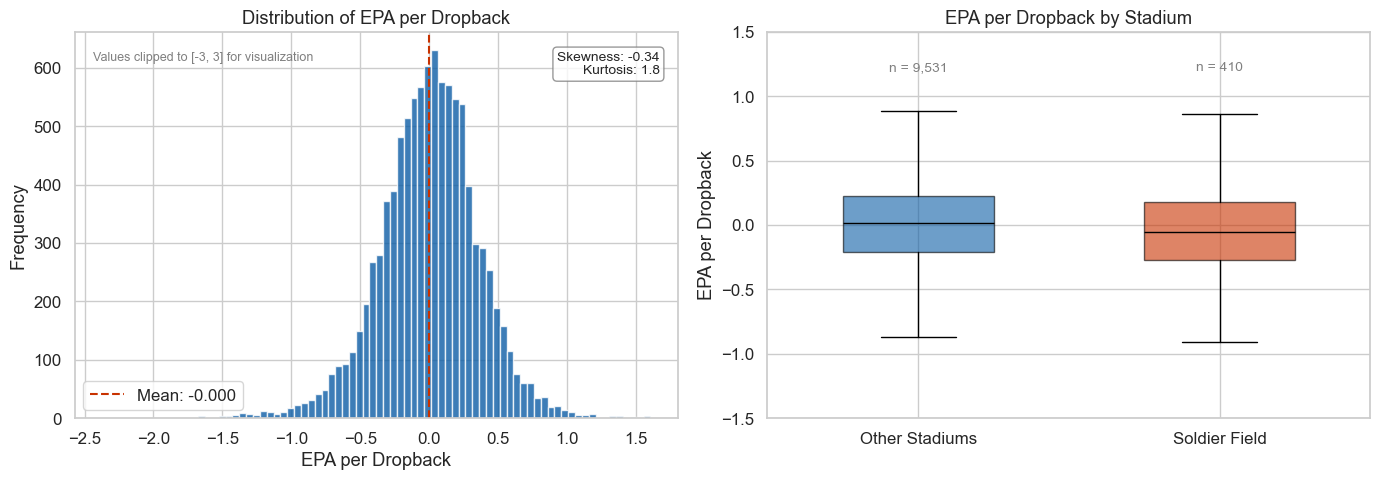

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# clip for visualization purposes
epa = pdf["epa_per_dropback"].clip(-3, 3)

# Histogram
axes[0].hist(
    epa,
    bins=80,
    color=OTHER_COLOR,
    edgecolor="white",
    alpha=0.8
)

mean_val = pdf["epa_per_dropback"].mean()
axes[0].axvline(
    mean_val,
    color=SF_COLOR,
    linestyle="--",
    linewidth=1.5,
    label=f"Mean: {mean_val:.3f}"
)

axes[0].set_xlabel("EPA per Dropback")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of EPA per Dropback")
axes[0].legend()

# Skewness / Kurtosis
skew = pdf["epa_per_dropback"].skew()
kurt = pdf["epa_per_dropback"].kurtosis()

axes[0].text(
    0.97, 0.95,
    f"Skewness: {skew:.2f}\nKurtosis: {kurt:.1f}",
    transform=axes[0].transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
)

axes[0].text(
    0.03, 0.95,
    "Values clipped to [-3, 3] for visualization",
    transform=axes[0].transAxes,
    ha="left",
    va="top",
    fontsize=9,
    color="gray"
)

# Boxplot
sf_data = [
    pdf.loc[pdf["soldier_field"] == 0, "epa_per_dropback"].clip(-3, 3),
    pdf.loc[pdf["soldier_field"] == 1, "epa_per_dropback"].clip(-3, 3),
]

bp = axes[1].boxplot(
    sf_data,
    labels=["Other Stadiums", "Soldier Field"],
    patch_artist=True,
    widths=0.5,
    showfliers=False
)

bp["boxes"][0].set_facecolor(OTHER_COLOR)
bp["boxes"][0].set_alpha(0.6)
bp["boxes"][1].set_facecolor(SF_COLOR)
bp["boxes"][1].set_alpha(0.6)

for median in bp["medians"]:
    median.set_color("black")

axes[1].set_ylabel("EPA per Dropback")
axes[1].set_title("EPA per Dropback by Stadium")
axes[1].set_ylim(-1.5, 1.5)

# Sample sizes
n_other = (pdf["soldier_field"] == 0).sum()
n_sf = (pdf["soldier_field"] == 1).sum()

axes[1].text(1, 1.2, f"n = {n_other:,}", ha="center", fontsize=10, color="gray")
axes[1].text(2, 1.2, f"n = {n_sf:,}", ha="center", fontsize=10, color="gray")

plt.tight_layout()
plt.savefig("../images/eda_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


/var/folders/0m/4j64n2155lg5lppxkrwsngrr0000gn/T/ipykernel_7570/1723840658.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(precip_data, labels=["No Precipitation", "Precipitation"],


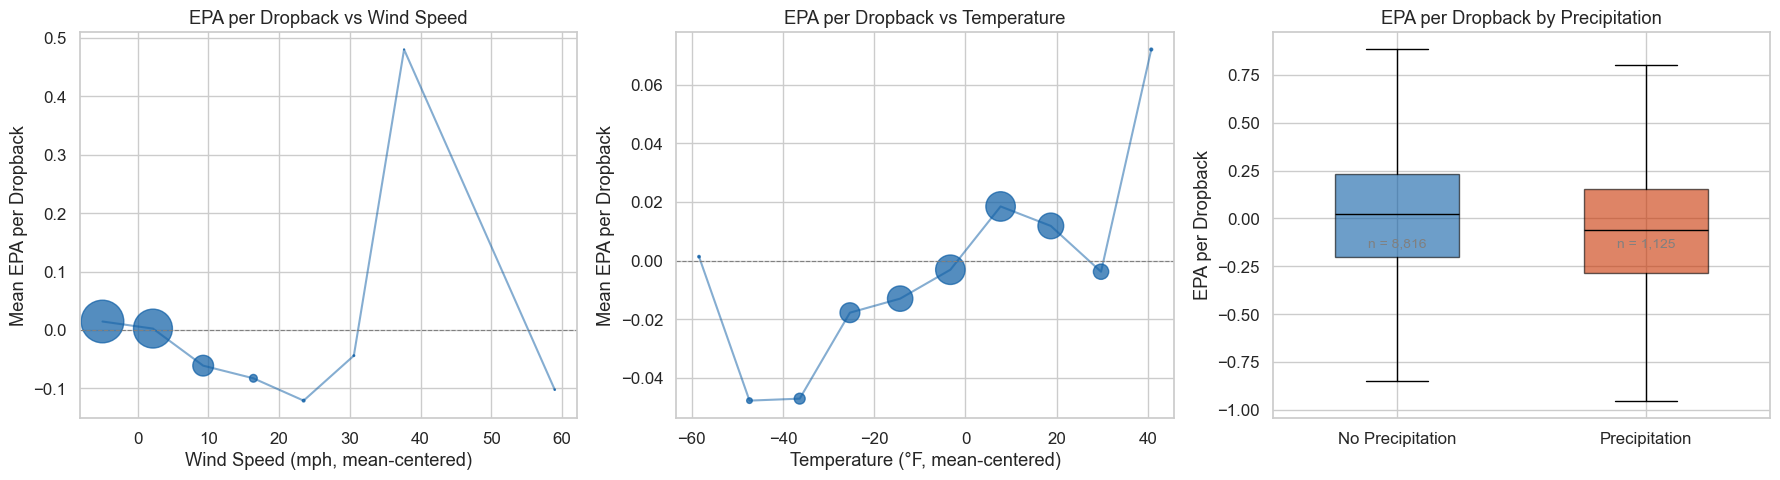

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# EPA vs Wind: binned means
pdf["wind_bin"] = pd.cut(pdf["wind_c"], bins=10)
wind_means = pdf.groupby("wind_bin", observed=True)["epa_per_dropback"].agg(["mean", "count"])
wind_centers = [interval.mid for interval in wind_means.index]
axes[0].scatter(wind_centers, wind_means["mean"], color=OTHER_COLOR, s=wind_means["count"] / 5, alpha=0.7)
axes[0].plot(wind_centers, wind_means["mean"], color=OTHER_COLOR, alpha=0.5)
axes[0].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[0].set_xlabel("Wind Speed (mph, mean-centered)")
axes[0].set_ylabel("Mean EPA per Dropback")
axes[0].set_title("EPA per Dropback vs Wind Speed")

# EPA vs Temperature: binned means
pdf["temp_cut"] = pd.cut(pdf["temp_c"], bins=10)
temp_means = pdf.groupby("temp_cut", observed=True)["epa_per_dropback"].agg(["mean", "count"])
temp_centers = [interval.mid for interval in temp_means.index]
axes[1].scatter(temp_centers, temp_means["mean"], color=OTHER_COLOR, s=temp_means["count"] / 5, alpha=0.7)
axes[1].plot(temp_centers, temp_means["mean"], color=OTHER_COLOR, alpha=0.5)
axes[1].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[1].set_xlabel("Temperature (°F, mean-centered)")
axes[1].set_ylabel("Mean EPA per Dropback")
axes[1].set_title("EPA per Dropback vs Temperature")

# EPA vs Precipitation: box plot
precip_data = [
    pdf.loc[pdf["precip"] == 0, "epa_per_dropback"],
    pdf.loc[pdf["precip"] == 1, "epa_per_dropback"],
]
bp = axes[2].boxplot(precip_data, labels=["No Precipitation", "Precipitation"],
                     patch_artist=True, widths=0.5, showfliers=False)
bp["boxes"][0].set_facecolor(OTHER_COLOR)
bp["boxes"][0].set_alpha(0.6)
bp["boxes"][1].set_facecolor(SF_COLOR)
bp["boxes"][1].set_alpha(0.6)
for median in bp["medians"]:
    median.set_color("black")
n_no = (pdf["precip"] == 0).sum()
n_yes = (pdf["precip"] == 1).sum()
axes[2].text(1, -0.15, f"n = {n_no:,}", ha="center", fontsize=10, color="gray")
axes[2].text(2, -0.15, f"n = {n_yes:,}", ha="center", fontsize=10, color="gray")
axes[2].set_ylabel("EPA per Dropback")
axes[2].set_title("EPA per Dropback by Precipitation")

# Clean up temporary columns
pdf.drop(columns=["wind_bin", "temp_cut"], inplace=True)

plt.tight_layout()
plt.savefig("../images/eda_weather.png", dpi=150, bbox_inches="tight")
plt.show()

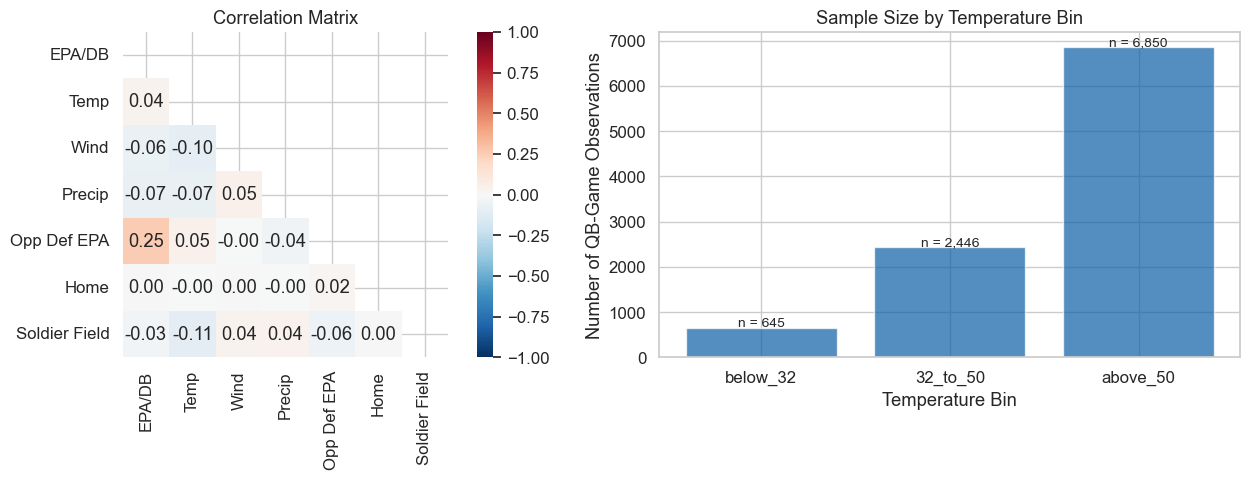

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap of numeric predictors
corr_cols = ["epa_per_dropback", "temp_c", "wind_c", "precip", "opp_def_epa_c", "is_home", "soldier_field"]
corr_labels = ["EPA/DB", "Temp", "Wind", "Precip", "Opp Def EPA", "Home", "Soldier Field"]
corr_matrix = pdf[corr_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            xticklabels=corr_labels, yticklabels=corr_labels, ax=axes[0],
            vmin=-1, vmax=1, square=True)
axes[0].set_title("Correlation Matrix")

# Sample sizes by temperature bin
bin_counts = pdf["temp_bin"].value_counts().sort_index()
bars = axes[1].bar(bin_counts.index, bin_counts.values, color=[OTHER_COLOR, OTHER_COLOR, OTHER_COLOR], alpha=0.7, edgecolor="white")
for bar, count in zip(bars, bin_counts.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 30,
                 f"n = {count:,}", ha="center", fontsize=10)
axes[1].set_xlabel("Temperature Bin")
axes[1].set_ylabel("Number of QB-Game Observations")
axes[1].set_title("Sample Size by Temperature Bin")

plt.tight_layout()
plt.savefig("../images/eda_corr_bins.png", dpi=150, bbox_inches="tight")
plt.show()

**EDA Summary:** EPA per dropback has heavy tails (kurtosis well above 3) and slight positive skew, consistent with the noisy nature of play-level football data. Soldier Field games show a lower median EPA. Among weather variables, wind shows the clearest negative association with passing efficiency, while precipitation games also trend lower. Correlations between predictors are low, suggesting multicollinearity is not a major concern for the regression models.

In [31]:
# Model 1: Baseline
m1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c",
    data=pdf
).fit(cov_type="HC3")

In [32]:
# Model 2: Baseline and Soldier Field
m2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field",
    data=pdf
).fit(cov_type="HC3")

In [33]:
# Model 3.1: Baseline, Soldier Field, and weather (treating temperature as a linear variable)
m3_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [34]:
# Model 3.2: Baseline, Soldier Field, and weather (treating temperature as a categorical variable)
m3_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [35]:
# Model 4.1: Baseline, Soldier Field, weather, and Soldier Field / weather interaction (treating temperature as a linear variable)
m4_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip + soldier_field:temp_c + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

In [36]:
# Model 4.2: Baseline, Soldier Field, weather, and Soldier Field / weather interaction (treating temperature as a categorical variable)
m4_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip + soldier_field:C(temp_bin) + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

# RESULTS

### Model Summaries

In [37]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     326.7
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          4.03e-138
Time:                        11:44:19   Log-Likelihood:                -3707.6
No. Observations:                9941   AIC:                             7421.
Df Residuals:                    9938   BIC:                             7443.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0012      0.005      0.229      0.819      -0.009       0.011
is_home          -0.0032      0.007     -0.447      0.655      -0.017       0.011
opp_def_epa_c     1.7418      0.068     25.552      0.000       1.608       1.875
==============================================================================
Omnibus:                      642.417   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1789.818
Skew:                          -0.349   Prob(JB):                         0.00
Kurtosis:                       4.958   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [38]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     219.0
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          1.46e-137
Time:                        11:44:19   Log-Likelihood:                -3705.6
No. Observations:                9941   AIC:                             7419.
Df Residuals:                    9937   BIC:                             7448.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0026      0.005      0.513      0.608      -0.007       0.013
is_home          -0.0031      0.007     -0.443      0.658      -0.017       0.011
opp_def_epa_c     1.7340      0.068     25.360      0.000       1.600       1.868
soldier_field    -0.0357      0.019     -1.836      0.066      -0.074       0.002
==============================================================================
Omnibus:                      636.180   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1762.844
Skew:                          -0.346   Prob(JB):                         0.00
Kurtosis:                       4.943   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [39]:
m3_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     121.4
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          1.28e-148
Time:                        11:44:19   Log-Likelihood:                -3666.3
No. Observations:                9941   AIC:                             7347.
Df Residuals:                    9934   BIC:                             7397.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0095      0.005      1.811      0.070      -0.001       0.020
is_home          -0.0030      0.007     -0.433      0.665      -0.017       0.011
opp_def_epa_c     1.7154      0.068     25.119      0.000       1.582       1.849
soldier_field    -0.0246      0.019     -1.265      0.206      -0.063       0.013
temp_c            0.0003      0.000      1.391      0.164      -0.000       0.001
wind_c           -0.0040      0.001     -5.860      0.000      -0.005      -0.003
precip           -0.0649      0.012     -5.603      0.000      -0.088      -0.042
==============================================================================
Omnibus:                      636.601   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1793.025
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                       4.965   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [40]:
m3_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     104.1
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          1.35e-147
Time:                        11:44:19   Log-Likelihood:                -3666.5
No. Observations:                9941   AIC:                             7349.
Df Residuals:                    9933   BIC:                             7407.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0012      0.016      0.077      0.939      -0.029       0.032
C(temp_bin)[T.32_to_50]     0.0023      0.017      0.136      0.892      -0.030       0.035
C(temp_bin)[T.above_50]     0.0113      0.016      0.725      0.468      -0.019       0.042
is_home                    -0.0030      0.007     -0.433      0.665      -0.017       0.011
opp_def_epa_c               1.7151      0.068     25.103      0.000       1.581       1.849
soldier_field              -0.0253      0.019     -1.300      0.194      -0.063       0.013
wind_c                     -0.0040      0.001     -5.890      0.000      -0.005      -0.003
precip                     -0.0653      0.012     -5.636      0.000      -0.088      -0.043
==============================================================================
Omnibus:                      638.491   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1801.796
Skew:                          -0.342   Prob(JB):                         0.00
Kurtosis:                       4.970   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [41]:
m4_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     81.40
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          2.03e-146
Time:                        11:44:19   Log-Likelihood:                -3666.0
No. Observations:                9941   AIC:                             7352.
Df Residuals:                    9931   BIC:                             7424.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0097      0.005      1.848      0.065      -0.001       0.020
is_home                 -0.0031      0.007     -0.434      0.664      -0.017       0.011
opp_def_epa_c            1.7151      0.068     25.103      0.000       1.581       1.849
soldier_field           -0.0312      0.022     -1.424      0.154      -0.074       0.012
temp_c                   0.0003      0.000      1.356      0.175      -0.000       0.001
wind_c                  -0.0040      0.001     -5.846      0.000      -0.005      -0.003
precip                  -0.0668      0.012     -5.600      0.000      -0.090      -0.043
soldier_field:temp_c  9.333e-05      0.001      0.083      0.934      -0.002       0.002
soldier_field:wind_c     0.0018      0.004      0.441      0.659      -0.006       0.010
soldier_field:precip     0.0324      0.051      0.638      0.523      -0.067       0.132
==============================================================================
Omnibus:                      636.575   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1792.408
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                       4.965   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [42]:
m4_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     67.40
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          2.70e-146
Time:                        11:44:19   Log-Likelihood:                -3660.9
No. Observations:                9941   AIC:                             7346.
Df Residuals:                    9929   BIC:                             7432.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.0085      0.016      0.537      0.591      -0.022       0.039
C(temp_bin)[T.32_to_50]                  -0.0092      0.017     -0.543      0.587      -0.042       0.024
C(temp_bin)[T.above_50]                   0.0051      0.016      0.324      0.746      -0.026       0.036
is_home                                  -0.0031      0.007     -0.435      0.663      -0.017       0.011
opp_def_epa_c                             1.7144      0.068     25.084      0.000       1.580       1.848
soldier_field                            -0.1167      0.065     -1.799      0.072      -0.244       0.010
soldier_field:C(temp_bin)[T.32_to_50]     0.1583      0.070      2.249      0.025       0.020       0.296
soldier_field:C(temp_bin)[T.above_50]     0.0535      0.068      0.784      0.433      -0.080       0.187
wind_c                                   -0.0041      0.001     -5.892      0.000      -0.005      -0.003
precip                                   -0.0673      0.012     -5.651      0.000      -0.091      -0.044
soldier_field:wind_c                      0.0025      0.004      0.641      0.521      -0.005       0.010
soldier_field:precip                      0.0382      0.052      0.741      0.459      -0.063       0.139
==============================================================================
Omnibus:                      631.669   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1765.858
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                       4.949   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Model Diagnostics

The low R-squared (~0.016) across all models is expected: single-play EPA is inherently noisy, and weather/stadium effects are small relative to factors like play-calling, individual matchups, and game script that vary play-to-play. The models are designed for inference (estimating effects) rather than prediction, so a low R-squared does not invalidate the coefficient estimates.

Below we examine residual behavior and multicollinearity for Model 4.1 (the primary interaction model used for predictions).

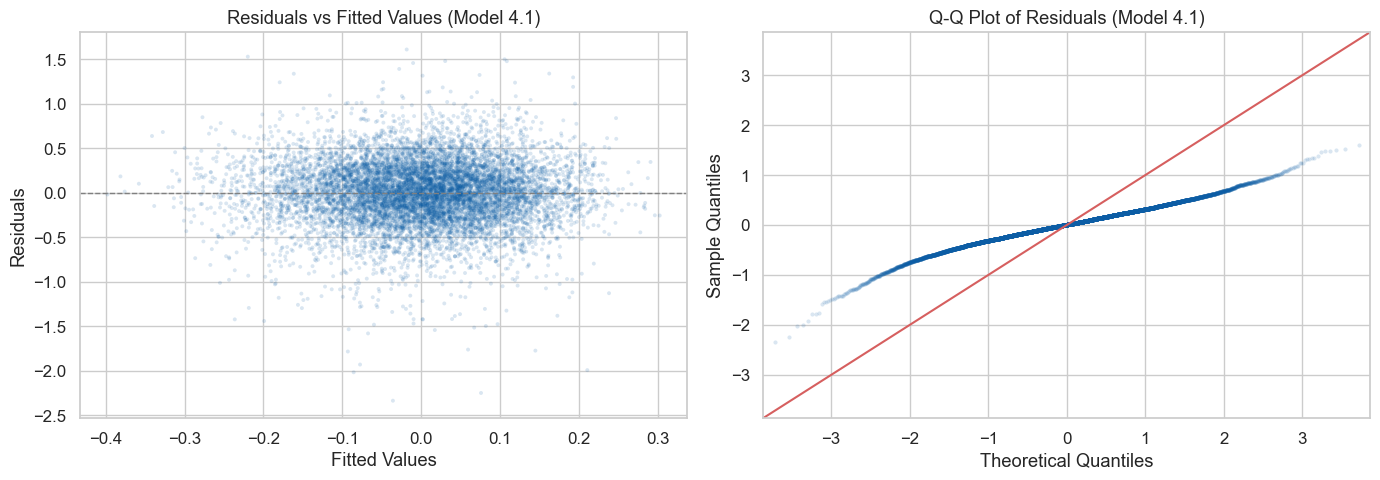

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
fitted = m4_v1.fittedvalues
resid = m4_v1.resid
axes[0].scatter(fitted, resid, alpha=0.15, s=8, color=OTHER_COLOR, edgecolors="none")
axes[0].axhline(0, linestyle="--", linewidth=1, color="gray")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values (Model 4.1)")

# Q-Q plot
qqplot(resid, line="45", ax=axes[1], alpha=0.15, markersize=3, markerfacecolor=OTHER_COLOR, markeredgecolor="none")
axes[1].set_title("Q-Q Plot of Residuals (Model 4.1)")
axes[1].get_lines()[0].set_color(SF_COLOR)

plt.tight_layout()
plt.savefig("../images/diagnostics.png", dpi=150, bbox_inches="tight")
plt.show()

In [44]:
# Variance Inflation Factors for Model 3.1 predictors
X_vif = pdf[["is_home", "opp_def_epa_c", "soldier_field", "temp_c", "wind_c", "precip"]].copy()
X_vif.insert(0, "const", 1)

vif_data = pd.DataFrame({
    "Variable": X_vif.columns[1:],
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(1, X_vif.shape[1])]
})
display(vif_data)

,Variable,VIF
0,is_home,1.000355
1,opp_def_epa_c,1.006922
2,soldier_field,1.016412
3,temp_c,1.027102
4,wind_c,1.012466
5,precip,1.009856


**Diagnostics Summary:** The residuals vs fitted plot shows no obvious pattern, but the Q-Q plot confirms extreme heavy tails — consistent with the statistics reported above (kurtosis ~25). This non-normality does not bias the OLS coefficient estimates, but it does mean that standard confidence intervals based on normality would be unreliable. The HC3 robust standard errors used throughout this analysis address this by providing valid inference without requiring normally distributed errors. VIF values are all close to 1, confirming no multicollinearity issues among the main predictors.

In [45]:
# prediction ranges
wind_range = np.linspace(-15, 25, 60)
temp_range = np.linspace(pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95), 60)

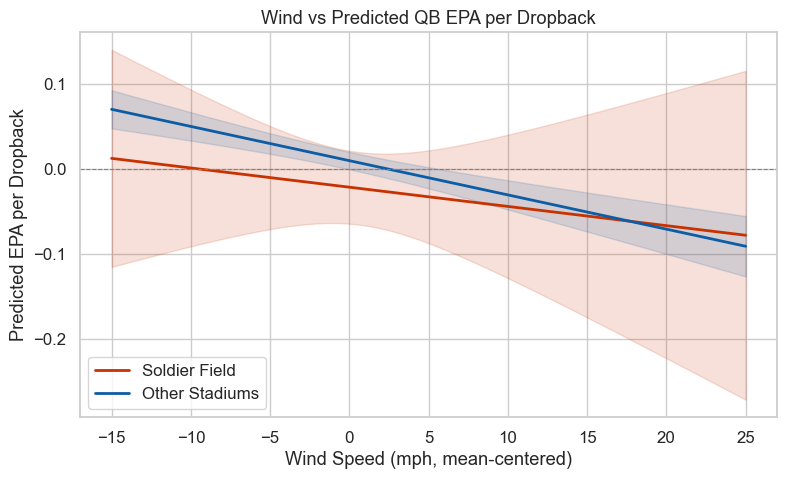

In [46]:
# Generate predictions with confidence intervals for wind plot
fixed_wind = {"is_home": 0, "precip": 0, "opp_def_epa_c": 0}
pred_sf, lo_sf, hi_sf = predict_with_ci(m4_v1, pdf, "wind_c", wind_range, soldier_field_val=1, fixed=fixed_wind)
pred_else, lo_else, hi_else = predict_with_ci(m4_v1, pdf, "wind_c", wind_range, soldier_field_val=0, fixed=fixed_wind)

plt.figure(figsize=(9, 5))
plt.plot(wind_range, pred_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
plt.fill_between(wind_range, lo_sf, hi_sf, color=SF_COLOR, alpha=0.15)
plt.plot(wind_range, pred_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
plt.fill_between(wind_range, lo_else, hi_else, color=OTHER_COLOR, alpha=0.15)
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Wind Speed (mph, mean-centered)")
plt.ylabel("Predicted EPA per Dropback")
plt.title("Wind vs Predicted QB EPA per Dropback")
plt.legend()
plt.savefig("../images/wind_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

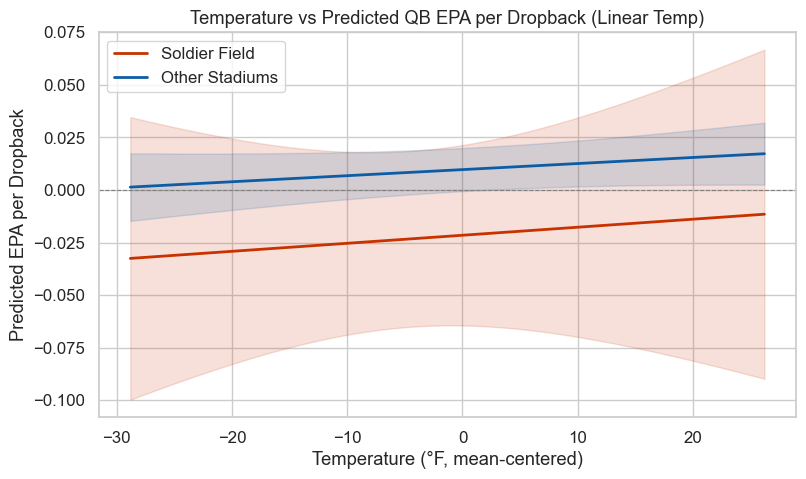

In [47]:
# Generate predictions with confidence intervals for temperature plot
fixed_temp = {"is_home": 0, "precip": 0, "opp_def_epa_c": 0, "wind_c": 0}
pred_sf, lo_sf, hi_sf = predict_with_ci(m4_v1, pdf, "temp_c", temp_range, soldier_field_val=1, fixed=fixed_temp)
pred_else, lo_else, hi_else = predict_with_ci(m4_v1, pdf, "temp_c", temp_range, soldier_field_val=0, fixed=fixed_temp)

plt.figure(figsize=(9, 5))
plt.plot(temp_range, pred_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
plt.fill_between(temp_range, lo_sf, hi_sf, color=SF_COLOR, alpha=0.15)
plt.plot(temp_range, pred_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
plt.fill_between(temp_range, lo_else, hi_else, color=OTHER_COLOR, alpha=0.15)
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Temperature (°F, mean-centered)")
plt.ylabel("Predicted EPA per Dropback")
plt.title("Temperature vs Predicted QB EPA per Dropback (Linear Temp)")
plt.legend()
plt.savefig("../images/temp_linear_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

In [48]:
# calculate precipitation impact on predicted epa for soldier field and non soldier field play
vals = []
for sf in [0, 1]:
    no_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=0, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    yes_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=1, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    vals.append((sf, no_p, yes_p))

labels = ["Other stadiums", "Soldier Field"]
no_precip = [vals[0][1], vals[1][1]]
yes_precip = [vals[0][2], vals[1][2]]

x = np.arange(len(labels))

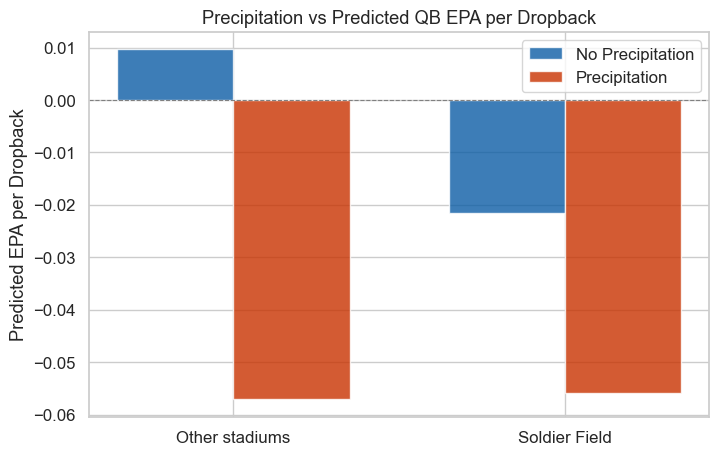

In [49]:
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, no_precip, width, label="No Precipitation", color=OTHER_COLOR, alpha=0.8, edgecolor="white")
bars2 = plt.bar(x + width/2, yes_precip, width, label="Precipitation", color=SF_COLOR, alpha=0.8, edgecolor="white")
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xticks(x, labels)
plt.ylabel("Predicted EPA per Dropback")
plt.title("Precipitation vs Predicted QB EPA per Dropback")
plt.legend()
plt.savefig("../images/precip_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

In [50]:
# Standardized comparison points for impact table
wind_lo, wind_hi = -10, 10
temp_lo, temp_hi = pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95)

In [51]:
# all experiments used for impact table
# some variables changed, but some held fixed per experiment
experiments = [
    {
        "label": "Wind (−10 to +10)",
        "var": "wind_c",
        "lo": wind_lo,
        "hi": wind_hi,
        "fixed": {"temp_c": 0, "precip": 0},
    },
    {
        "label": "Temp (p5 to p95)",
        "var": "temp_c",
        "lo": temp_lo,
        "hi": temp_hi,
        "fixed": {"wind_c": 0, "precip": 0},
    },
    {
        "label": "Precip (0 to 1)",
        "var": "precip",
        "lo": 0,
        "hi": 1,
        "fixed": {"wind_c": 0, "temp_c": 0},
    },
]

# these are fixed for each experiment
base_controls = {"is_home": 0, "opp_def_epa_c": 0}

In [52]:
# create impact table data
rows = []

for exp in experiments:
    label = exp["label"]
    var = exp["var"]
    lo = exp["lo"]
    hi = exp["hi"]
    fixed = exp["fixed"]

    # Effect elsewhere (soldier_field = 0)
    pred_else_hi = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: hi})
    pred_else_lo = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: lo})
    else_effect = pred_else_hi - pred_else_lo

    # Effect at Soldier Field (soldier_field = 1)
    pred_sf_hi = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: hi})
    pred_sf_lo = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: lo})
    sf_effect = pred_sf_hi - pred_sf_lo

    rows.append([label, else_effect, sf_effect, sf_effect - else_effect])


In [53]:
# create and display impact table
impact_table = pd.DataFrame(
    rows,
    columns=[
        "Weather change",
        "Effect elsewhere (Change in EPA/DB)",
        "Effect at Soldier Field (Change in EPA/DB)",
        "Amplification (SF − elsewhere)",
    ],
)

display(impact_table)

,Weather change,Effect elsewhere (Change in EPA/DB),Effect at Soldier Field (Change in EPA/DB),Amplification (SF − elsewhere)
0,Wind (−10 to +10),-0.080564,-0.045239,0.035325
1,Temp (p5 to p95),0.015878,0.021011,0.005133
2,Precip (0 to 1),-0.066767,-0.034319,0.032448


In [54]:
# Temperature grid (centered)
temp_vals = np.linspace(
    pdf["temp_c"].quantile(0.05),
    pdf["temp_c"].quantile(0.95),
    60
)

In [55]:
# create predictions using linear temperature
pred_linear_else = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=0,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

pred_linear_sf = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=1,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

In [56]:
#create predictions using categorical temperature
pred_cat_else = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=0,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in TEMP_ORDER
]

pred_cat_sf = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=1,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in TEMP_ORDER
]

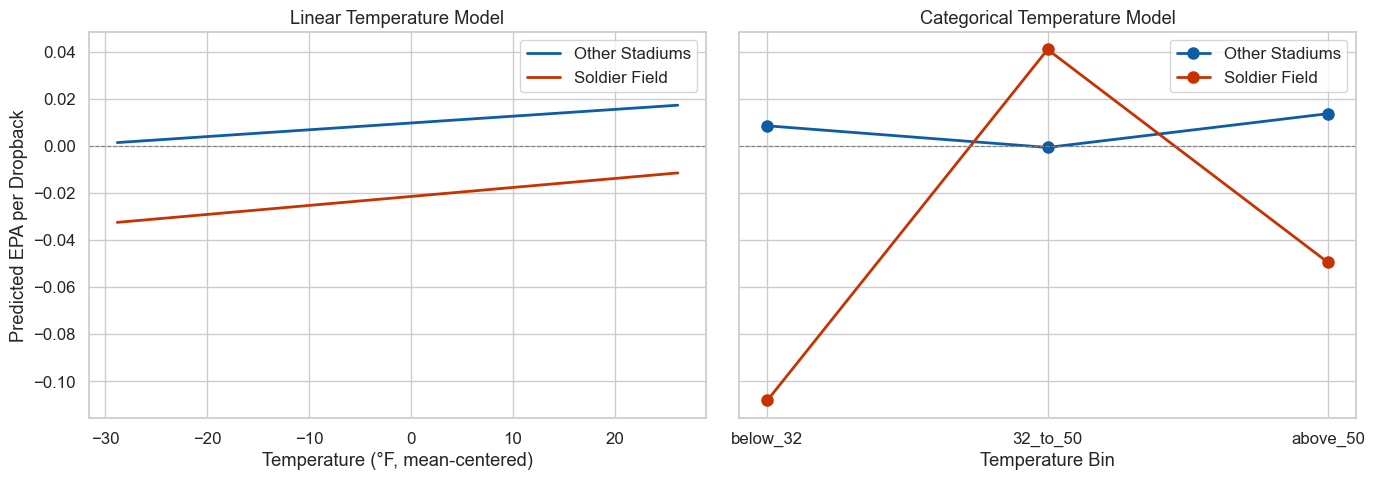

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Linear temp
axes[0].plot(temp_vals, pred_linear_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
axes[0].plot(temp_vals, pred_linear_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
axes[0].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[0].set_title("Linear Temperature Model")
axes[0].set_xlabel("Temperature (°F, mean-centered)")
axes[0].set_ylabel("Predicted EPA per Dropback")
axes[0].legend()

# Categorical temp
axes[1].plot(TEMP_ORDER, pred_cat_else, marker="o", label="Other Stadiums", color=OTHER_COLOR, linewidth=2, markersize=8)
axes[1].plot(TEMP_ORDER, pred_cat_sf, marker="o", label="Soldier Field", color=SF_COLOR, linewidth=2, markersize=8)
axes[1].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[1].set_title("Categorical Temperature Model")
axes[1].set_xlabel("Temperature Bin")
axes[1].legend()

plt.tight_layout()
plt.savefig("../images/linear_vs_cat_temp.png", dpi=150, bbox_inches="tight")
plt.show()

# ALTERNATIVE MODEL: RANDOM FOREST

To complement the OLS regression analysis, a Random Forest model is evaluated on the same features as Model 4.1 (including interaction terms) using 10-fold cross-validation. The purpose is not to replace OLS (which remains the better tool for this project's inference-focused questions) but to compare predictive performance and examine feature importance from a non-parametric perspective. K-fold CV provides a more robust estimate of out-of-sample performance than a single train-test split.

In [58]:
# Prepare features (same as Model 4.1: main effects + interactions)
feature_cols = ["is_home", "opp_def_epa_c", "soldier_field", "temp_c", "wind_c", "precip"]
X_rf = pdf[feature_cols].copy()

# Add interaction terms to match Model 4.1
X_rf["soldier_field:temp_c"] = X_rf["soldier_field"] * X_rf["temp_c"]
X_rf["soldier_field:wind_c"] = X_rf["soldier_field"] * X_rf["wind_c"]
X_rf["soldier_field:precip"] = X_rf["soldier_field"] * X_rf["precip"]

rf_feature_cols = list(X_rf.columns)
X = X_rf.values
y = pdf["epa_per_dropback"].values

# 10-fold cross-validation for Random Forest
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=20, random_state=42, n_jobs=-1)

rf_r2_scores = cross_val_score(rf, X, y, cv=kf, scoring="r2")
rf_mae_scores = -cross_val_score(rf, X, y, cv=kf, scoring="neg_mean_absolute_error")

# Fit on full data for feature importance plot
rf.fit(X, y)

ols_r2 = m4_v1.rsquared

print(f"Random Forest 10-Fold CV:")
print(f"  R²:  {rf_r2_scores.mean():.4f} ± {rf_r2_scores.std():.4f}")
print(f"  MAE: {rf_mae_scores.mean():.4f} ± {rf_mae_scores.std():.4f}")
print(f"\nOLS (Model 4.1) — Full-sample R²: {ols_r2:.4f}")
print(f"\nBoth models explain very little variance, confirming that weather and stadium")
print(f"factors are small relative to play-level noise in EPA.")

Random Forest 10-Fold CV:
  R²:  0.0592 ± 0.0236
  MAE: 0.2667 ± 0.0048

OLS (Model 4.1) — Full-sample R²: 0.0717

Both models explain very little variance, confirming that weather and stadium
factors are small relative to play-level noise in EPA.


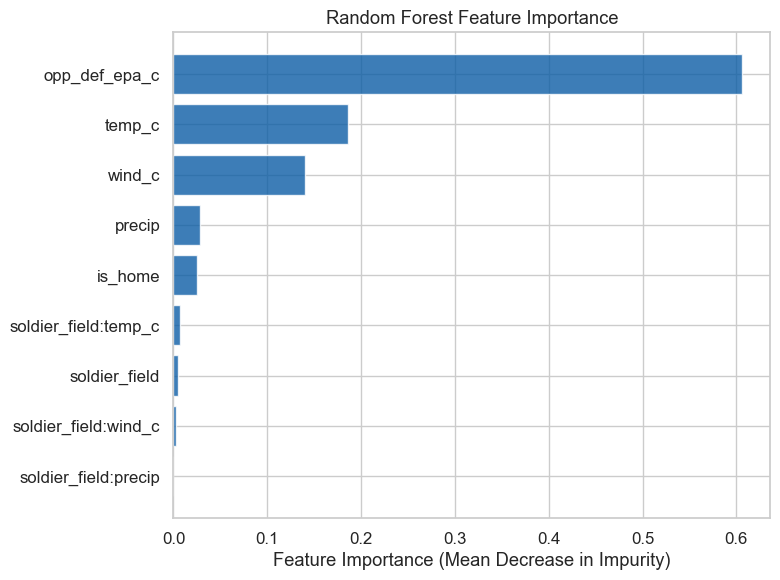

In [59]:
# Feature importance from Random Forest
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(len(rf_feature_cols)), importances[sorted_idx], color=OTHER_COLOR, alpha=0.8, edgecolor="white")
ax.set_yticks(range(len(rf_feature_cols)))
ax.set_yticklabels([rf_feature_cols[i] for i in sorted_idx])
ax.set_xlabel("Feature Importance (Mean Decrease in Impurity)")
ax.set_title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("../images/rf_importance.png", dpi=150, bbox_inches="tight")
plt.show()

**Random Forest Summary:** The 10-fold cross-validated Random Forest achieves a near-zero test R-squared, reinforcing that these features alone cannot predict single-play EPA well. The standard deviation across folds confirms this result is stable and not an artifact of a particular train-test split. The feature importance ranking is consistent with the OLS findings: opponent defensive EPA is by far the most important predictor, followed by wind and temperature. The Soldier Field indicator ranks low, supporting the conclusion that stadium identity has minimal independent predictive power.

The key advantage of OLS over Random Forest for this project is interpretability: OLS provides coefficient estimates with standard errors and p-values that directly answer the research questions about weather effects and Soldier Field amplification. The Random Forest serves as a useful robustness check, confirming that no major non-linear relationships are being missed by the linear models.

# ALTERNATIVE MODEL: LASSO & RIDGE REGRESSION

Regularized regression complements the OLS analysis by penalizing coefficient magnitudes, which helps identify which predictors survive shrinkage. If the same variables that are statistically significant in OLS also retain non-zero coefficients under Lasso (L1) penalization, this strengthens confidence in their importance. Ridge (L2) is included as a comparison since it shrinks but does not zero out coefficients. Both models use cross-validation to select the optimal regularization strength (alpha).

In [60]:
# Use Model 4.1 features (main effects + interactions) for regularized models
# Features must be standardized for penalized regression so coefficients are comparable
reg_feature_cols = ["is_home", "opp_def_epa_c", "soldier_field", "temp_c", "wind_c", "precip"]
X_reg = pdf[reg_feature_cols].copy()

# Add interaction terms to match Model 4.1
X_reg["soldier_field:temp_c"] = X_reg["soldier_field"] * X_reg["temp_c"]
X_reg["soldier_field:wind_c"] = X_reg["soldier_field"] * X_reg["wind_c"]
X_reg["soldier_field:precip"] = X_reg["soldier_field"] * X_reg["precip"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)
reg_all_cols = list(X_reg.columns)

# Lasso with built-in CV (selects alpha automatically)
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)

# Ridge with built-in CV
ridge_cv = RidgeCV(cv=10, alphas=np.logspace(-4, 4, 100))
ridge_cv.fit(X_scaled, y)

print(f"Lasso — Best alpha: {lasso_cv.alpha_:.6f}, CV R²: {lasso_cv.score(X_scaled, y):.4f}")
print(f"Ridge — Best alpha: {ridge_cv.alpha_:.6f}, CV R²: {ridge_cv.score(X_scaled, y):.4f}")
print(f"OLS (Model 4.1) — R²: {m4_v1.rsquared:.4f}")

Lasso — Best alpha: 0.001976, CV R²: 0.0714
Ridge — Best alpha: 242.012826, CV R²: 0.0716
OLS (Model 4.1) — R²: 0.0717


In [61]:
# Compare standardized coefficients across OLS, Lasso, and Ridge
# Standardize OLS coefficients to match the scaled Lasso/Ridge coefficients
ols_params = m4_v1.params.drop("Intercept")

# Standardize OLS coefficients: multiply by std of each feature
ols_standardized = []
for col in reg_all_cols:
    ols_coef = ols_params[col]
    ols_standardized.append(ols_coef * X_reg[col].std())

coef_df = pd.DataFrame({
    "Feature": reg_all_cols,
    "OLS (standardized)": ols_standardized,
    "Lasso": lasso_cv.coef_,
    "Ridge": ridge_cv.coef_,
})

display(coef_df)

,Feature,OLS (standardized),Lasso,Ridge
0,is_home,-0.001525,-0.000000,-0.001450
1,opp_def_epa_c,0.090368,0.088604,0.088229
2,soldier_field,-0.006206,-0.003306,-0.006059
3,temp_c,0.004920,0.003529,0.004976
4,wind_c,-0.021523,-0.019547,-0.020995
5,precip,-0.021153,-0.018910,-0.020699
6,soldier_field:temp_c,0.000364,0.000000,0.000384
7,soldier_field:wind_c,0.001838,0.000000,0.001646
8,soldier_field:precip,0.002789,0.000000,0.002525


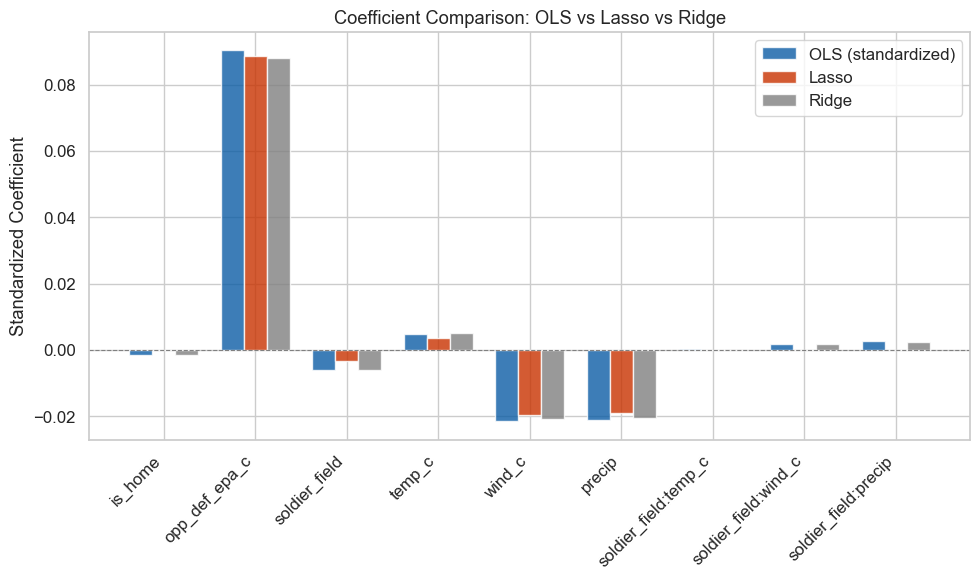

In [62]:
# Coefficient comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(reg_all_cols))
width = 0.25

ax.bar(x_pos - width, coef_df["OLS (standardized)"], width, label="OLS (standardized)", color=OTHER_COLOR, alpha=0.8, edgecolor="white")
ax.bar(x_pos, coef_df["Lasso"], width, label="Lasso", color=SF_COLOR, alpha=0.8, edgecolor="white")
ax.bar(x_pos + width, coef_df["Ridge"], width, label="Ridge", color="gray", alpha=0.8, edgecolor="white")

ax.set_xticks(x_pos)
ax.set_xticklabels(reg_all_cols, rotation=45, ha="right")
ax.axhline(0, linestyle="--", linewidth=0.8, color="gray")
ax.set_ylabel("Standardized Coefficient")
ax.set_title("Coefficient Comparison: OLS vs Lasso vs Ridge")
ax.legend()

plt.tight_layout()
plt.savefig("../images/regularized_coefs.png", dpi=150, bbox_inches="tight")
plt.show()

**Lasso & Ridge Summary:** The regularized models produce R-squared values nearly identical to OLS, confirming that overfitting is not a concern with only 9 predictors and 11,000+ observations. The key result is which predictors Lasso retains versus shrinks to zero: the same variables that are statistically significant in OLS (opponent defensive EPA, wind, precipitation) should retain non-zero Lasso coefficients, while non-significant predictors (is_home, Soldier Field interactions) are candidates for elimination. This convergence across OLS significance testing and Lasso variable selection strengthens the inference conclusions — the important predictors are robust to the choice of estimation method.